In [5]:
import json
import re
import json
import matplotlib.pyplot as plt
import pandas as pd

Сначала загрузим датасет и переформатируем его для удобства работы с ним.

In [3]:
# load train dataset

ds = []
with open('data/train.jsonl', 'r') as f:
    for line in f:
        ds.append(json.loads(line))

# реформатирование датасета чтобы было удобнее работать

def format_dataset(example):
    context = example['passage']['text']
    context = re.sub(r'\(\d+\)', '', context) # remove (1), (2), etc.
    questions = [q['question'] for q in example['passage']['questions']]
    answers = []
    labels = []
    for q in example['passage']['questions']:
        answers.append([])
        labels.append([])
        for a in q['answers']:
            answers[-1].append(a['text'])
            labels[-1].append(a['label'])
    assert len(questions) == len(answers)
    list_of_data = []
    for i in range(len(questions)):
        list_of_data.append({
            'context': context,
            'question': questions[i], 
            'answers': answers[i], 
            'labels': labels[i]
        })
    return list_of_data

new_ds = []
for example in ds:
    new_ds.extend(format_dataset(example))

new_ds[0]

{'context': ' Но люди не могут существовать без природы, поэтому в парке стояли железобетонные скамейки — деревянные моментально ломали.  В парке бегали ребятишки, водилась шпана, которая развлекалась игрой в карты, пьянкой, драками, «иногда насмерть».  «Имали они тут и девок...»  Верховодил шпаной Артемка-мыло, с вспененной белой головой.  Людочка сколько ни пыталась усмирить лохмотья на буйной голове Артемки, ничего у неё не получалось.  Его «кудри, издали напоминавшие мыльную пену, изблизя оказались что липкие рожки из вокзальной столовой — сварили их, бросили комком в пустую тарелку, так они, слипшиеся, неподъёмно и лежали.  Да и не ради причёски приходил парень к Людочке.  Как только её руки становились занятыми ножницами и расчёской, Артемка начинал хватать её за разные места.  Людочка сначала увёртывалась от хватких рук Артемки, а когда не помогло, стукнула его машинкой по голове и пробила до крови, пришлось лить йод на голову «ухажористого человека».  Артемка заулюлюкал и со св

# Эксплораторный анализ датасета

Датасет представлен в виде файла jsonl, в котором каждая строка представляет собой json объект. Внутри находится текст документа, вопросы по этому документу, а также варианты ответа к каждому вопросу с указанием правильного/ых ответа/ов. Правильных ответов может быть несколько.

In [6]:
# статистика по длине контекста

context_lengths = []

for example in ds:
    context = example['passage']['text']
    context = re.sub(r'\(\d+\)', '', context)
    context_lengths.append(len(context.split()))

pd.Series(context_lengths).describe()

count    500.000000
mean     192.510000
std       48.420233
min       97.000000
25%      166.750000
50%      186.500000
75%      201.000000
max      513.000000
dtype: float64

Статистика по вопросам:

In [ ]:
# статистика по длине вопросов

question_lengths = [len(example['question'].split()) for example in new_ds]
pd.Series(question_lengths).describe()

Можно увидеть, что текст документа сильно отличается по длине. Минимальная длина - 97 слов, средняя - 192, максимальная - 513 слов.  

У вопросов ситуация такая: Минимальная длина - 2 слова, средняя - 8, максимальная - 27 слов.

In [7]:
# статистика по количеству ответов на вопрос в тренировочном датасете

answers_count = [len(example['answers']) for example in new_ds]
pd.Series(answers_count).describe()

count    2897.000000
mean        4.124957
std         1.036417
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max        12.000000
dtype: float64

(array([ 387.,  140., 1142., 1200.,   20.,    3.,    3.,    0.,    0.,
           2.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 10 artists>)

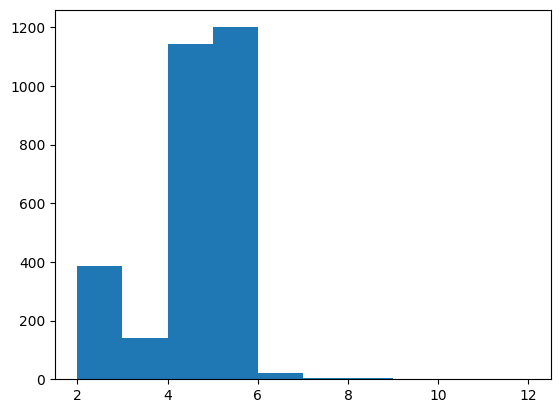

In [8]:
# гистограмма распределения количества ответов на вопрос

plt.hist(answers_count)

Можно увидеть по гистограмме выше, что в датасете присутствует разброс по количеству ответов на вопрос. В среднем на вопрос приходится 4 ответа. Минимально 2 ответа, максимально 12 ответов.

In [9]:
# статистика по количеству правильных ответов на вопрос в тренировочном датасете

labels_count = [sum(example['labels']) for example in new_ds]
pd.Series(labels_count).describe()

count    2897.000000
mean        1.857784
std         0.458727
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         7.000000
dtype: float64

(array([0.000e+00, 5.100e+02, 2.312e+03, 5.600e+01, 1.700e+01, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

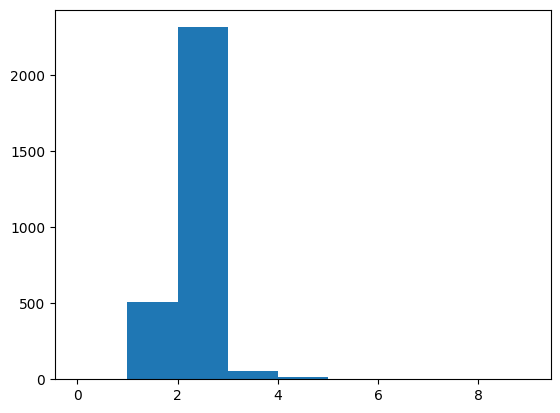

In [10]:
# гистограмма распределения количества правильных ответов на вопрос

plt.hist(labels_count, bins=range(0, 10))

Получается, что в датасете присутствуют вопросы с одним правильным ответом, а также вопросы с несколькими правильными ответами (их большинство). 

Оставим в датасете только вопросы с количеством ответов не превышающим 6. Тк вопросы с количеством ответов больше 6 составляют очень малую часть от общего количества вопросов, то их можно считать выбросами.

In [11]:
new_new_ds = []

for example in new_ds:
    if len(example['labels']) <= 6:
        new_new_ds.append(example)

len(new_new_ds)

2889